### Notebook to check horizontal and vertical resolution of nested child model and shelfstrat. 
This is for Section 2 of the manuscript

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 13})
import matplotlib.dates as mdates
import matplotlib.ticker as tick

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

# from dask.distributed import Client
# client = Client()

In [2]:
#Nested child grid
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_00*.nc')
ds = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, Vtransform = 2)

### Mean resolution over entire domain

In [9]:
print(np.sqrt(np.mean(ds.dx.values)*np.mean(ds.dy.values)))
print(np.mean(np.sqrt((ds.dx.values)*(ds.dy.values))))

316.1688620758845
314.7982073532551


### Mean resolution close to the coast versus offshore
Plot the child model domain to make sure our indexing is right following Schlichting et al. (2023) *JAMES*

Text(-93.5, 27.52, 'Child')

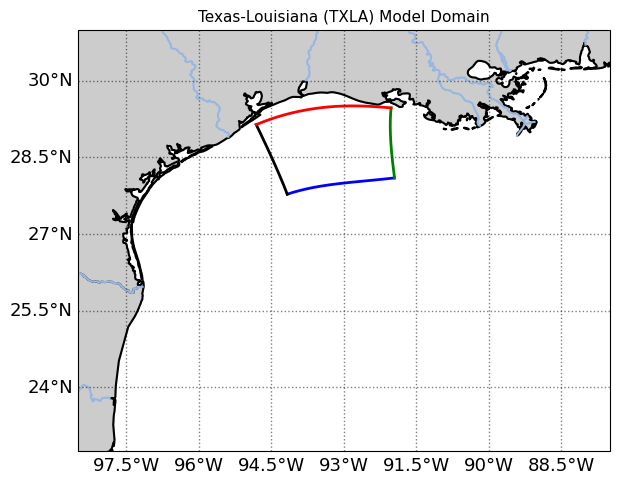

In [24]:
fig,ax = plt.subplots(1, figsize = (5.4,4.5), subplot_kw={'projection': crs}, constrained_layout = True)

ax.set_extent([-98.5, -87.5, 22.75, 31], ccrs.PlateCarree())

#Shade each boundary with different colors to identify the indexing
ax.plot(ds.lon_rho[0,:], ds.lat_rho[0,:], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds.lon_rho[:,0], ds.lat_rho[:,0], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds.lon_rho[:,-1], ds.lat_rho[:,-1], 'g', lw=2,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds.lon_rho[-1,:], ds.lat_rho[-1,:], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)

#Lat and lon grid lines
gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

#Map features from cartopy. Add land, coastline, borders and rivers. 
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1.5)
ax.coastlines(resolution='10m', linewidth = 1.5)  
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.add_feature(cartopy.feature.RIVERS, linewidth=1.5)
ax.set_aspect('auto') #aspect ratio

#Add text to landmarks/title
ax.set_title('Texas-Louisiana (TXLA) Model Domain', fontsize = 11)
ax.annotate('Child', xy = (-93.5, 27.52), color = 'r', rotation = 10, fontsize = 10, fontweight='bold')

In [26]:
print(np.mean(np.sqrt((ds.dx[0,:].values)*(ds.dy[0,:].values))))
print(np.mean(np.sqrt((ds.dx[-1,:].values)*(ds.dy[-1,:].values))))

339.44926539444674
324.20693248055034


In [30]:
#Check individual components 
print(ds.dx.max().values)
print(ds.dy.max().values)

print(ds.dx.min().values)
print(ds.dy.min().values)

469.8615015054841
370.12633139050445
316.99300317861235
205.2595816959398


In [32]:
print(np.min(np.sqrt(ds.dx.values*ds.dy.values)))
print(np.max(np.sqrt(ds.dx.values*ds.dy.values)))

#Compare with dA metric
print(np.min(np.sqrt(ds.dA.values)))
print(np.max(np.sqrt(ds.dA.values)))

255.3613618100264
357.5270749834118


In [45]:
#Southern boundary 
print(np.min(np.sqrt(ds.dA[0,:].values)))
print(np.max(np.sqrt(ds.dA[0,:].values)))
#Coast
print(np.min(np.sqrt(ds.dA[-1,:].values)))
print(np.max(np.sqrt(ds.dA[-1,:].values)))

319.4919817919659
350.0820201142442
258.8454386874464
357.5270749834118


### Now examine vertical grid parameters

In [54]:
print(ds.theta_s.values)
print(ds.theta_b.values)

5.0
0.4


### Top one meter 

In [60]:
#Instantaneous depth that includes SSH
print(ds.dz[0].where(ds.z_rho[0,:]>-1).mean().values)
print(ds.dz[100].where(ds.z_rho[100,:]>-1).mean().values)
print(ds.dz[500].where(ds.z_rho[500,:]>-1).mean().values)

0.3621823398405948
0.365240856210758
0.3711418953644179


In [64]:
# SSH removed
print(ds.dz0.where(ds.z_rho0>-1).min().values)
print(ds.dz0.where(ds.z_rho0>-1).max().values)
print(ds.dz0.where(ds.z_rho0>-1).mean().values)

0.12990445887369997
0.7291594709142302
0.37776709597706654


In [65]:
#Offshore
print(ds.dz0[:,0,:].where(ds.z_rho0[:,0,:]>-1).min().values)
print(ds.dz0[:,0,:].where(ds.z_rho0[:,0,:]>-1).max().values)
print(ds.dz0[:,0,:].where(ds.z_rho0[:,0,:]>-1).mean().values)

0.5655490565944319
0.7274811417438546
0.6131006315063554


In [66]:
#Close to the coast 
print(ds.dz0[:,-1,:].where(ds.z_rho0[:,-1,:]>-1).min().values)
print(ds.dz0[:,-1,:].where(ds.z_rho0[:,-1,:]>-1).max().values)
print(ds.dz0[:,-1,:].where(ds.z_rho0[:,-1,:]>-1).mean().values)

0.13317206745319748
0.3166147456287587
0.22852731669334186


### Whole water column 

In [70]:
#All
print(ds.dz0.min().values)
print(ds.dz0.max().values)
print(ds.dz0.mean().values)

0.12990445887369997
36.938314338800865
1.2667827123437125


In [73]:
#Offshore
print(ds.dz0[:,0,:].min().values)
print(ds.dz0[:,0,:].max().values)
print(ds.dz0[:,0,:].mean().values)

0.5655490565944319
36.938314338800865
4.191474443561742


In [69]:
#Close to the coast 
print(ds.dz0[:,-1,:].min().values)
print(ds.dz0[:,-1,:].max().values)
print(ds.dz0[:,-1,:].mean().values)

0.13317206745319748
1.336343192228993
0.38655831193921947


### Close to the bottom 

In [74]:
#All
print(ds.dz0[0].min().values)
print(ds.dz0[0].max().values)
print(ds.dz0[0].mean().values)

0.2523766448256115
36.938314338800865
3.804264554516669


### Now compare with shelfstrat

In [75]:
path_s = '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zero_dt_30_60d_avg.nc'
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,721))
    return ds1, grid1

dss, grids = open_roms(path_s)
    
etaslice = slice(1,100)
xislice = slice(1,-1)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [76]:
dss

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:         (tracer: 5, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 194, xi_rho: 194, xi_u: 193, eta_v: 193, ocean_time: 721)
Coordinates: (12/29)
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    x_rho           (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
    y_rho           (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
    x_u             (eta_rho, xi_u) float64 dask.array<chunksize=(194, 193), meta=np.ndarray>
    y_u             (eta_rho, xi_u) float64 dask.array<chunksize=(194, 193), meta=np.ndarray>
    ...              ...
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(30, 193, 194), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(30, 193, 193), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 194, 194), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 194, 193), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 193, 194), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 193, 193), meta=np.ndarray>
Dimensions without coordinates: tracer, Nuser
Data variables: (12/146)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          object ...
    nHIS            int32 ...
    ...              ...
    dV_u            (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 194, 193), meta=np.ndarray>
    dV_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 194, 193), meta=np.ndarray>
    dV_v            (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 193, 194), meta=np.ndarray>
    dV_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 193, 194), meta=np.ndarray>
    dV_psi          (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 30, 193, 193), meta=np.ndarray>
    dV_w_psi        (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 193, 193), meta=np.ndarray>
Attributes: (12/28)
    file:              shelf_dx_500_mpdata_uwind_zero_dt_30_60d/shelf_mpdata_...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             SHELFSTRAT
    var_info:          /scratch/user/dylan.schlichting/COAWST/ROMS/External/v...
    ...                ...
    compiler_command:  /sw/eb/sw/impi/2019.9.304-iccifort-2020.4.304/intel64/...
    compiler_flags:    -fp-model precise -ip -O3 -traceback
    tiling:            016x004
    history:           ROMS/TOMS, Version 3.9, Thursday - September 21, 2023 ...
    ana_file:          /scratch/user/dylan.schlichting/COAWST/Projects/shelfs...
    CPP_options:       SHELFSTRAT, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_FS...

In [77]:
dss.dz0

<xarray.DataArray 'dz0' (s_rho: 30, eta_rho: 194, xi_rho: 194)>
dask.array<sub, shape=(30, 194, 194), dtype=float64, chunksize=(30, 194, 194), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.08333 -0.05 -0.01667
    x_rho    (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 186 187 188 189 190 191 192 193
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 186 187 188 189 190 191 192 193
    z_rho0   (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 194, 194), meta=np.ndarray>
Attributes:
    long_name:  vertical layer thickness on vertical RHO grid
    field:      dz0, scalar
    units:      m
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...

### Top one meter 

In [81]:
### Whole domain
print(dss.dz0.where(dss.z_rho0>-1).min().values)
print(dss.dz0.where(dss.z_rho0>-1).max().values)
print(dss.dz0.where(dss.z_rho0>-1).mean().values)

### Initially stratified region
print(dss.dz0.isel(eta_rho = etaslice, xi_rho = xislice).where(dss.z_rho0>-1).min().values)
print(dss.dz0.isel(eta_rho = etaslice, xi_rho = xislice).where(dss.z_rho0>-1).max().values)
print(dss.dz0.isel(eta_rho = etaslice, xi_rho = xislice).where(dss.z_rho0>-1).mean().values)

0.08391009106290724
0.32761938144404545
0.18908855184648748
0.08391009106290724
0.26814437628010557
0.16406689667626898


### Whole water column 

In [82]:
### Whole domain
print(dss.dz0.min().values)
print(dss.dz0.max().values)
print(dss.dz0.mean().values)

### Initially stratified region
print(dss.dz0.isel(eta_rho = etaslice, xi_rho = xislice).min().values)
print(dss.dz0.isel(eta_rho = etaslice, xi_rho = xislice).max().values)
print(dss.dz0.isel(eta_rho = etaslice, xi_rho = xislice).mean().values)

0.08391009106290724
13.075784697273974
1.7582916900258896
0.08391009106290724
6.783113358119984
0.9832977269069176
